Author: Ganesh Morye

# Motivation behind the Project
Twitter is one of the most popular social media platforms, and it currently has over [396.5 million](https://backlinko.com/twitter-users) users. Twitter is a microblogging and social networking service. Users post *tweets*, short text messages to interact with their followers. The text content of a tweet can contain up to 280 characters. Users can post and talk about any topic they wish to, provided they do not violate the Twitter rules. Given the open platform nature of the service, Twitter attracts a wide range and variety of users and topics, and users of the platform use it as an outlet to discuss and inform their viewpoints. Twitter is a valuable text mining data pool that can be leveraged to discover the underlying themes of conversations happening at any given time. E.g., an organization would like to understand the discussions around their products. However, manually reading and making sense of all the tweets to identify the themes and topics of discussions is not always practical. A text mining approach can be adopted to get a *big picture* idea of general discussion topics. Topic modeling can help distill information into a more usable and actionable format.<br>
I analyze the Twitter activity of users from **India** over the last two years (Sep-2019 to Sep-2020). *Topic models* are used to discover and identify trends in the underlying themes in the topics being discussed on the platform. COVID played a big part in the last two years and greatly influenced how users interacted on social media platforms. Topic models can provide insights into any specific trends that could correlate with the rise and the fall in the number of COVID cases in India. Since topic modeling is an unsupervised machine learning technique, our analysis and results are driven by how well the topic models capture the relevant topics. 
# Problem Statement
As a data science engineer at Twitter-India, I am tasked to improve Twitter's search algorithm to show more context-based results rather than just query-based results. I use topic models to discover latent themes in the users' posts specifically originating from India to improve the search engine's performance. Helping users find relevant information will lead to more engagement on the platform and drive user monetization.

# General Outline of this notebook
- **Data Collection** - Set up the Snscrape API to scrape twitter feeds for last 2 years
- **Data Preparation** - Process all the csv files and read them into a DataFrame
- **Data Cleaning** - Cleaning of data, primarily to remove misaligned data rows, tweets outside India, missing location data
- **EDA** - Preliminary Data QC, EDA and Visualizations
- **Discussion on Data Uncertainity and Risks**

# Importing Libraries

In [1]:
import pandas as pd
import snscrape.modules.twitter as sntwitter
import itertools
import datetime
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
import os, glob
import re
import requests
from bs4 import BeautifulSoup # library to parse HTML documents
import feather

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
import numpy as np

# Scraping List of Cities in India

In [3]:
# get the response in the form of html
wikiurl="https://en.wikipedia.org/wiki/List_of_cities_in_India_by_population"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)
print(response.status_code)

200


In [4]:
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')
indiatable=soup.find('table',{'class':"wikitable"})

In [5]:
df=pd.read_html(str(indiatable))
# convert list to dataframe
df=pd.DataFrame(df[0])
(df.head())

,Rank,City,Population(2011)[3],Population(2001),State or union territory
0,1,Mumbai,12442373,11978450,Maharashtra
1,2,Delhi,11007835,9879172,Delhi
2,3,Bangalore,8425970,4301326,Karnataka
3,4,Hyderabad,6809970,3637483,Telangana
4,5,Ahmedabad,5570585,3520085,Gujarat


In [6]:
# drop the unwanted columns
data = df.drop(["Rank", "Population(2001)"], axis=1)
# rename columns for ease
data = data.rename(columns={"State or union territory": "State","Population(2011)[3]": "Population"})
(data.head())
df =[]

In [7]:
all_cities = data['City'].to_list()

def remove(all_cities):
    pattern = '[0-9]'
    all_cities = [re.sub(pattern, '', i) for i in all_cities] #removes number from city name Vishakhpatnam[4] = Vishakhapatnam[]
    all_cities = [i.replace('[','').replace(']','') for i in all_cities] #removes square brackets from city name Vishakhpatnam[] = Vishakhapatnam
    return all_cities

all_cities = remove(all_cities)

all_cities = ['Bengaluru'] + all_cities

In [8]:
all_cities[0:]

['Bengaluru',
 'Mumbai',
 'Delhi',
 'Bangalore',
 'Hyderabad',
 'Ahmedabad',
 'Chennai',
 'Kolkata',
 'Surat',
 'Pune',
 'Jaipur',
 'Lucknow',
 'Kanpur',
 'Nagpur',
 'Indore',
 'Thane',
 'Bhopal',
 'Visakhapatnam',
 'Pimpri-Chinchwad',
 'Patna',
 'Vadodara',
 'Ghaziabad',
 'Ludhiana',
 'Agra',
 'Coimbatore',
 'Nashik',
 'Ranchi',
 'Faridabad',
 'Meerut',
 'Rajkot',
 'Kalyan-Dombivli',
 'Vasai-Virar',
 'Varanasi',
 'Srinagar',
 'Aurangabad',
 'Dhanbad',
 'Gurgaon',
 'Amritsar',
 'Navi Mumbai',
 'Allahabad',
 'Howrah',
 'Gwalior',
 'Jabalpur',
 'Vijayawada',
 'Jodhpur',
 'Salem',
 'Madurai',
 'Raipur',
 'Kota',
 'Chandigarh',
 'Guwahati',
 'Solapur',
 'Hubli–Dharwad',
 'Mysore',
 'Tiruchirappalli',
 'Bareilly',
 'Aligarh',
 'Tiruppur',
 'Moradabad',
 'Jalandhar',
 'Bhubaneswar',
 'Warangal',
 'Mira-Bhayandar',
 'Jalgaon',
 'Guntur',
 'Thiruvananthapuram',
 'Bhiwandi',
 'Saharanpur',
 'Gorakhpur',
 'Bikaner',
 'Amravati',
 'Noida',
 'Jamshedpur',
 'Bhilai',
 'Cuttack',
 'Firozabad',
 'Koc

In [45]:
# city = 'Mumbai'

# Scraping Tweets

## Setting up Date Parameters

In [53]:
sdate = date(2019,9,1)   # start date
edate = date(2021,11,20)   # end date

dates = pd.date_range(sdate,edate-timedelta(days=1),freq='m')
dates = dates.date

In [9]:
tweet_dir = '../tweets_data'

## Functions to Scrape Tweets by City

In [97]:
# scraping tweets for top 25 cities by retweets and faves filter

def scrape_by_city(city):
    tweet_filename = city + 'tweets.csv'
    tweet_file = os.path.join(tweet_dir, tweet_filename)
    print (f'Writing tweets to {tweet_file}')
    month='Null'
    print(f'Scraping tweets for {city}')
    for since in dates:
        until = since + relativedelta(months=1)
        if since.month != month:
            print (f'Processing tweets for Dates Since {since} Until {until}')
            month = since.month
        df = pd.DataFrame((sntwitter.TwitterSearchScraper(
        f'near:{city} within:200km since:{since} until:{until} lang:en -filter:retweets -filter:replies filter:has_engagement min_retweets:50 OR min_faves:50').get_items()))
        print (f'Number of tweets scraped {len(df)}')
        df.to_csv(tweet_file, mode='a', header = not os.path.exists(tweet_file))


# for city in ['Delhi'] + all_cities[16:25]: #top 25 cities, mumbai was already scraped
for city in ['Delhi', 'Ghaziabad', 'Bengaluru']:
    scrape_by_city(city)

Writing tweets to ./tweets_data/Delhitweets.csv
Scraping tweets for Delhi
Processing tweets for Dates Since 2019-09-30 Until 2019-10-30
Number of tweets scraped 1522
Processing tweets for Dates Since 2019-10-31 Until 2019-11-30
Number of tweets scraped 1998
Processing tweets for Dates Since 2019-11-30 Until 2019-12-30
Number of tweets scraped 2477
Processing tweets for Dates Since 2019-12-31 Until 2020-01-31
Number of tweets scraped 2703
Processing tweets for Dates Since 2020-01-31 Until 2020-02-29
Number of tweets scraped 2002
Processing tweets for Dates Since 2020-02-29 Until 2020-03-29
Number of tweets scraped 1754
Processing tweets for Dates Since 2020-03-31 Until 2020-04-30
Number of tweets scraped 1433
Processing tweets for Dates Since 2020-04-30 Until 2020-05-30
Number of tweets scraped 1643
Processing tweets for Dates Since 2020-05-31 Until 2020-06-30
Number of tweets scraped 2100
Processing tweets for Dates Since 2020-06-30 Until 2020-07-30
Number of tweets scraped 1754
Proces

In [98]:
# scraping tweets for top 25 cities for verified handles

def scrape_by_city(city):
    tweet_filename = city + 'verifiedtweets.csv'
    tweet_file = os.path.join(tweet_dir, tweet_filename)
    print (f'Writing tweets to {tweet_file}')
    month='Null'
    print(f'Scraping tweets for {city}')
    for since in dates:
        until = since + relativedelta(months=1)
        if since.month != month:
            print (f'Processing tweets for Dates Since {since} Until {until}')
            month = since.month
        df = pd.DataFrame((sntwitter.TwitterSearchScraper(
        f'near:{city} within:200km since:{since} until:{until} lang:en -filter:retweets -filter:replies filter:verified').get_items()))
        print (f'Number of tweets scraped {len(df)}')
        df.to_csv(tweet_file, mode='a', header = not os.path.exists(tweet_file))


for city in all_cities[:26]:
    scrape_by_city(city)

Writing tweets to ./tweets_data/Bengaluruverifiedtweets.csv
Scraping tweets for Bengaluru
Processing tweets for Dates Since 2019-09-30 Until 2019-10-30
Number of tweets scraped 725
Processing tweets for Dates Since 2019-10-31 Until 2019-11-30
Number of tweets scraped 1023
Processing tweets for Dates Since 2019-11-30 Until 2019-12-30
Number of tweets scraped 1218
Processing tweets for Dates Since 2019-12-31 Until 2020-01-31
Number of tweets scraped 1053
Processing tweets for Dates Since 2020-01-31 Until 2020-02-29
Number of tweets scraped 649
Processing tweets for Dates Since 2020-02-29 Until 2020-03-29
Number of tweets scraped 1021
Processing tweets for Dates Since 2020-03-31 Until 2020-04-30
Number of tweets scraped 866
Processing tweets for Dates Since 2020-04-30 Until 2020-05-30
Number of tweets scraped 815
Processing tweets for Dates Since 2020-05-31 Until 2020-06-30
Number of tweets scraped 799
Processing tweets for Dates Since 2020-06-30 Until 2020-07-30
Number of tweets scraped 

## Scraping Tweets by Country - India

In [101]:
# Scraping tweets for India based on place object of twitter API

tweet_filename = 'India' + 'tweets.csv'
tweet_file = os.path.join(tweet_dir, tweet_filename)
place = 'b850c1bfd38f30e0' 
print (f'Writing tweets to {tweet_file}')
month='Null'
print(f'Scraping tweets for India')

for since in dates:
    until = since + relativedelta(months=1)
    if since.month != month:
        print (f'Processing tweets for Dates Since {since} Until {until}')
        month = since.month
    df = pd.DataFrame((sntwitter.TwitterSearchScraper(
            # f'place:{place} since:{since} until:{until} lang:en -filter:retweets -filter:replies filter:has_engagement min_retweets:50 OR min_faves:50').get_items()))
            f'near:India since:{since} until:{until} lang:en -filter:retweets -filter:replies filter:has_engagement min_retweets:50 OR min_faves:50 OR filter:verified').get_items()))
    print (f'Number of tweets scraped {len(df)}')
    df.to_csv(tweet_file, mode='a', header = not os.path.exists(tweet_file))
df = []

Writing tweets to ./tweets_data/Indiatweets.csv
Scraping tweets for India
Processing tweets for Dates Since 2019-09-30 Until 2019-10-30
Number of tweets scraped 26498
Processing tweets for Dates Since 2019-10-31 Until 2019-11-30
Number of tweets scraped 30914
Processing tweets for Dates Since 2019-11-30 Until 2019-12-30
Number of tweets scraped 32296
Processing tweets for Dates Since 2019-12-31 Until 2020-01-31
Number of tweets scraped 33888
Processing tweets for Dates Since 2020-01-31 Until 2020-02-29
Number of tweets scraped 29116
Processing tweets for Dates Since 2020-02-29 Until 2020-03-29
Number of tweets scraped 32829
Processing tweets for Dates Since 2020-03-31 Until 2020-04-30
Number of tweets scraped 32173
Processing tweets for Dates Since 2020-04-30 Until 2020-05-30
Number of tweets scraped 28436
Processing tweets for Dates Since 2020-05-31 Until 2020-06-30
Number of tweets scraped 25797
Processing tweets for Dates Since 2020-06-30 Until 2020-07-30
Number of tweets scraped 25

## Combining Scrapped Tweet CSV Files to DataFrame

In [266]:
parse_dates = ['date']


tweet_files = glob.glob(os.path.join(tweet_dir, '*.csv'))

li = []
for file in tweet_files:
    city = os.path.basename(file).replace('tweets.csv', '').title()
    print (f'Processing file = {file} for place = {city}')
    tweet_df = pd.read_csv(file, index_col=None, header=0, parse_dates = parse_dates, infer_datetime_format=True).assign(filename = city)
    li.append(tweet_df)

df = pd.concat(li, axis=0, ignore_index=True)
tweet_df=[]
li =[]
print('Done!!!')

# df = pd.read_csv('mumbaitweets.csv', parse_dates = parse_dates, infer_datetime_format=True, index_col=False)
# df

Processing file = ../tweets_data/Kolkataverifiedtweets.csv with Kolkataverified = data
Processing file = ../tweets_data/Bengalurutweets.csv with Bengaluru = data
Processing file = ../tweets_data/Puneverifiedtweets.csv with Puneverified = data
Processing file = ../tweets_data/Chennaitweets.csv with Chennai = data
Processing file = ../tweets_data/Ranchiverifiedtweets.csv with Ranchiverified = data
Processing file = ../tweets_data/Ranchitweets.csv with Ranchi = data
Processing file = ../tweets_data/Suratverifiedtweets.csv with Suratverified = data
Processing file = ../tweets_data/Kanpurverifiedtweets.csv with Kanpurverified = data
Processing file = ../tweets_data/Lucknowtweets.csv with Lucknow = data
Processing file = ../tweets_data/Vadodaraverifiedtweets.csv with Vadodaraverified = data
Processing file = ../tweets_data/Ludhianatweets.csv with Ludhiana = data
Processing file = ../tweets_data/Vadodaratweets.csv with Vadodara = data
Processing file = ../tweets_data/Nagpurtweets.csv with Nag

/Users/ganeshmorye/miniforge3/envs/twint/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,8,9,10,11,19,21,22,27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Processing file = ../tweets_data/Hyderabadverifiedtweets.csv with Hyderabadverified = data
Processing file = ../tweets_data/Punetweets.csv with Pune = data
Processing file = ../tweets_data/Lucknowverifiedtweets.csv with Lucknowverified = data
Processing file = ../tweets_data/Hyderabadtweets.csv with Hyderabad = data
Processing file = ../tweets_data/Agraverifiedtweets.csv with Agraverified = data
Processing file = ../tweets_data/Thaneverifiedtweets.csv with Thaneverified = data
Processing file = ../tweets_data/Delhitweets.csv with Delhi = data


/Users/ganeshmorye/miniforge3/envs/twint/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,8,9,10,11,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Processing file = ../tweets_data/Ludhianaverifiedtweets.csv with Ludhianaverified = data
Processing file = ../tweets_data/Bengaluruverifiedtweets.csv with Bengaluruverified = data
Processing file = ../tweets_data/Ahmedabadtweets.csv with Ahmedabad = data
Processing file = ../tweets_data/Agratweets.csv with Agra = data
Processing file = ../tweets_data/Indoreverifiedtweets.csv with Indoreverified = data
Processing file = ../tweets_data/Nagpurverifiedtweets.csv with Nagpurverified = data
Processing file = ../tweets_data/Bangaloreverifiedtweets.csv with Bangaloreverified = data
Processing file = ../tweets_data/Patnatweets.csv with Patna = data
Processing file = ../tweets_data/Kanpurtweets.csv with Kanpur = data
Processing file = ../tweets_data/Bhopaltweets.csv with Bhopal = data
Processing file = ../tweets_data/Indiatweets.csv with India = data


/Users/ganeshmorye/miniforge3/envs/twint/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,1,3,4,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Processing file = ../tweets_data/Jaipurtweets.csv with Jaipur = data
Processing file = ../tweets_data/Chennaiverifiedtweets.csv with Chennaiverified = data


/Users/ganeshmorye/miniforge3/envs/twint/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (3,4,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Processing file = ../tweets_data/Pimpri-Chinchwadverifiedtweets.csv with Pimpri-Chinchwadverified = data
Processing file = ../tweets_data/Mumbaitweets.csv with Mumbai = data
Processing file = ../tweets_data/Delhiverifiedtweets.csv with Delhiverified = data


/Users/ganeshmorye/miniforge3/envs/twint/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,8,9,10,11,19,21,22,27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Processing file = ../tweets_data/Ghaziabadtweets.csv with Ghaziabad = data


/Users/ganeshmorye/miniforge3/envs/twint/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,8,9,10,11,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Processing file = ../tweets_data/Pimpri-Chinchwadtweets.csv with Pimpri-Chinchwad = data
Processing file = ../tweets_data/Nashikverifiedtweets.csv with Nashikverified = data
Processing file = ../tweets_data/Visakhapatnamtweets.csv with Visakhapatnam = data
Processing file = ../tweets_data/Patnaverifiedtweets.csv with Patnaverified = data
Processing file = ../tweets_data/Thanetweets.csv with Thane = data
Processing file = ../tweets_data/Kolkatatweets.csv with Kolkata = data
Processing file = ../tweets_data/Ahmedabadverifiedtweets.csv with Ahmedabadverified = data
Processing file = ../tweets_data/Nashiktweets.csv with Nashik = data
Processing file = ../tweets_data/Bangaloretweets.csv with Bangalore = data
Processing file = ../tweets_data/Surattweets.csv with Surat = data
Processing file = ../tweets_data/Bhopalverifiedtweets.csv with Bhopalverified = data
Processing file = ../tweets_data/Jaipurverifiedtweets.csv with Jaipurverified = data
Processing file = ../tweets_data/Indoretweets.csv 

# EDA

## Cleaning the Data

In [267]:
df.shape

(2101020, 29)

In [268]:
df.head(2)

,Unnamed: 0,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,...,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,filename
0,0,https://twitter.com/Chandrakbose/status/118927...,2019-10-29 20:23:57+00:00,Three generations celebrating Bhai Phonta at L...,Three generations celebrating Bhai Phonta at L...,1.189277e+18,"{'username': 'Chandrakbose', 'id': 313199215, ...",1.0,4,83,...,NaN,NaN,NaN,NaN,NaN,"{'longitude': 88.094457, 'latitude': 22.269493}","{'fullName': 'Kolkata, India', 'name': 'Kolkat...",NaN,NaN,Kolkataverified
1,1,https://twitter.com/marcelinholeite/status/118...,2019-10-29 17:21:34+00:00,Just delighted to score my 1st goal with new t...,Just delighted to score my 1st goal with new t...,1.189231e+18,"{'username': 'marcelinholeite', 'id': 32630976...",13.0,17,315,...,NaN,NaN,NaN,NaN,NaN,"{'longitude': 86.067565, 'latitude': 22.212044}","{'fullName': 'Jamshedpur, India', 'name': 'Jam...",NaN,NaN,Kolkataverified


In [269]:
df = df.drop_duplicates(subset='url')

In [270]:
df.shape

(1001382, 29)

In [271]:
df.isnull().sum()

Unnamed: 0                0
url                       1
date                     16
content                  16
renderedContent          31
id                       31
user                     31
replyCount               31
retweetCount             31
likeCount                31
quoteCount               31
conversationId           31
lang                     45
source                   45
sourceUrl                36
sourceLabel              46
outlinks             610462
tcooutlinks          610463
media                525944
retweetedTweet      1001377
quotedTweet          824970
inReplyToTweetId    1001368
inReplyToUser       1001375
mentionedUsers       663534
coordinates          346585
place                346516
hashtags             504890
cashtags            1000076
filename                  0
dtype: int64

In [272]:
df.dropna(subset=['user'], inplace=True)

In [273]:
df.drop(columns = ['Unnamed: 0'], inplace=True)

In [274]:
mask = df[~df['url'].str.contains('http')].index #some rows were shifted. data was not scraped appropriately. deleting those 20-30 entries
mask

Int64Index([  10153,   41310,  205058,  216095,  235934,  235974,  277250,
             681582,  810740,  927702,  989238, 1067616, 1154689, 1156380,
            1382454],
           dtype='int64')

In [275]:
df = df.drop(mask)

In [276]:
df.reset_index(inplace=True)

In [277]:
df.isnull().sum()

index                     0
url                       0
date                      0
content                   0
renderedContent           0
id                        0
user                      0
replyCount                0
retweetCount              0
likeCount                 0
quoteCount                0
conversationId            0
lang                      0
source                    0
sourceUrl                 0
sourceLabel               0
outlinks             610417
tcooutlinks          610417
media                525898
retweetedTweet      1001336
quotedTweet          824938
inReplyToTweetId    1001336
inReplyToUser       1001336
mentionedUsers       663488
coordinates          346539
place                346470
hashtags             504844
cashtags            1000030
filename                  0
dtype: int64

In [278]:
df.shape

(1001336, 29)

In [279]:
(df['user'])

0          {'username': 'Chandrakbose', 'id': 313199215, ...
1          {'username': 'marcelinholeite', 'id': 32630976...
2          {'username': 'stephenbudd', 'id': 30051646, 'd...
3          {'username': 'stephenbudd', 'id': 30051646, 'd...
4          {'username': 'stephenbudd', 'id': 30051646, 'd...
                                 ...                        
1001331    {'username': 'MadhaviGoddeti', 'id': 120940836...
1001332    {'username': 'PRO_Vizag', 'id': 3269981695, 'd...
1001333    {'username': 'PRO_Vizag', 'id': 3269981695, 'd...
1001334    {'username': 'PRO_Vizag', 'id': 3269981695, 'd...
1001335    {'username': 'PRO_Vizag', 'id': 3269981695, 'd...
Name: user, Length: 1001336, dtype: object

In [280]:
type(df['user'][0])

str

In [281]:
df['user'][0]

"{'username': 'Chandrakbose', 'id': 313199215, 'displayname': 'Chandra Kumar Bose', 'description': 'Rights Activist,Crusader against corruption.Bharatiya who believes in communal harmony for development & national pride.This is my only Twitter account.', 'rawDescription': 'Rights Activist,Crusader against corruption.Bharatiya who believes in communal harmony for development & national pride.This is my only Twitter account.', 'descriptionUrls': None, 'verified': True, 'created': datetime.datetime(2011, 6, 8, 8, 56, 21, tzinfo=datetime.timezone.utc), 'followersCount': 37143, 'friendsCount': 933, 'statusesCount': 11337, 'favouritesCount': 4778, 'listedCount': 55, 'mediaCount': 2530, 'location': 'kolkata', 'protected': False, 'linkUrl': 'https://chandrakumarbose.wordpress.com/', 'linkTcourl': 'https://t.co/vR8Isfw6kc', 'profileImageUrl': 'https://pbs.twimg.com/profile_images/1260485981616078849/SpK2E6xt_normal.jpg', 'profileBannerUrl': 'https://pbs.twimg.com/profile_banners/313199215/15730

**Certain columns are stored as string dictionary. Converting them into a Python Dictionary and creating a new column for each key**

## Manipulating the User Column

In [282]:
import datetime
import ast
import re

def eval_manual(e):
    return eval(e)
df['user'] =  df['user'].apply(eval_manual)

In [283]:
df['user']

0          {'username': 'Chandrakbose', 'id': 313199215, ...
1          {'username': 'marcelinholeite', 'id': 32630976...
2          {'username': 'stephenbudd', 'id': 30051646, 'd...
3          {'username': 'stephenbudd', 'id': 30051646, 'd...
4          {'username': 'stephenbudd', 'id': 30051646, 'd...
                                 ...                        
1001331    {'username': 'MadhaviGoddeti', 'id': 120940836...
1001332    {'username': 'PRO_Vizag', 'id': 3269981695, 'd...
1001333    {'username': 'PRO_Vizag', 'id': 3269981695, 'd...
1001334    {'username': 'PRO_Vizag', 'id': 3269981695, 'd...
1001335    {'username': 'PRO_Vizag', 'id': 3269981695, 'd...
Name: user, Length: 1001336, dtype: object

In [284]:
df_user = pd.json_normalize(df['user'])


In [285]:
df_user.columns

Index(['username', 'id', 'displayname', 'description', 'rawDescription',
       'descriptionUrls', 'verified', 'created', 'followersCount',
       'friendsCount', 'statusesCount', 'favouritesCount', 'listedCount',
       'mediaCount', 'location', 'protected', 'linkUrl', 'linkTcourl',
       'profileImageUrl', 'profileBannerUrl', 'label', 'label.description',
       'label.url', 'label.badgeUrl', 'label.longDescription'],
      dtype='object')

## Manipulating the Place Column

In [288]:
def eval_manual(e):
    try:
        return eval(e)
    except TypeError:
        return np.nan
df['place'] = df['place'].apply(eval_manual)

In [289]:
df_place = pd.json_normalize(df['place'])

In [290]:
df_place

,fullName,name,type,country,countryCode
0,"Kolkata, India",Kolkata,city,India,IN
1,"Jamshedpur, India",Jamshedpur,city,India,IN
2,"Kolkata, India",Kolkata,city,India,IN
3,"Kolkata, India",Kolkata,city,India,IN
4,"Kolkata, India",Kolkata,city,India,IN
...,...,...,...,...,...
1001331,"Vishakhapatnam, India",Vishakhapatnam,city,India,IN
1001332,NaN,NaN,NaN,NaN,NaN
1001333,NaN,NaN,NaN,NaN,NaN
1001334,NaN,NaN,NaN,NaN,NaN


In [291]:
df_place.columns

Index(['fullName', 'name', 'type', 'country', 'countryCode'], dtype='object')

## Manipulating the Coordinates Column

In [292]:
df['coordinates'] = df['coordinates'].apply(eval_manual)

In [293]:
df_coordinates = pd.json_normalize(df['coordinates'])

In [294]:
df_coordinates

,longitude,latitude
0,88.094457,22.269493
1,86.067565,22.212044
2,88.094457,22.269493
3,88.094457,22.269493
4,88.094457,22.269493
...,...,...
1001331,83.117424,17.578131
1001332,NaN,NaN
1001333,NaN,NaN
1001334,NaN,NaN


In [295]:
df_coordinates.columns

Index(['longitude', 'latitude'], dtype='object')

In [296]:
df['verified_flag'] = df['filename'].apply(lambda x: 'Y' if 'verified' in x else 'N')

In [297]:
df['filename'] = df['filename'].apply(lambda x: x.replace('verified', '') if 'verified' in x else x)

## Concatenating DataFrames

In [298]:
df = pd.concat([df, df_user, df_place, df_coordinates], axis=1)

In [299]:
df.columns

Index(['index', 'url', 'date', 'content', 'renderedContent', 'id', 'user',
       'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
       'conversationId', 'lang', 'source', 'sourceUrl', 'sourceLabel',
       'outlinks', 'tcooutlinks', 'media', 'retweetedTweet', 'quotedTweet',
       'inReplyToTweetId', 'inReplyToUser', 'mentionedUsers', 'coordinates',
       'place', 'hashtags', 'cashtags', 'filename', 'verified_flag',
       'username', 'id', 'displayname', 'description', 'rawDescription',
       'descriptionUrls', 'verified', 'created', 'followersCount',
       'friendsCount', 'statusesCount', 'favouritesCount', 'listedCount',
       'mediaCount', 'location', 'protected', 'linkUrl', 'linkTcourl',
       'profileImageUrl', 'profileBannerUrl', 'label', 'label.description',
       'label.url', 'label.badgeUrl', 'label.longDescription', 'fullName',
       'name', 'type', 'country', 'countryCode', 'longitude', 'latitude'],
      dtype='object')

In [300]:
df.shape

(1001336, 62)

## Writing to CSV File - Master Tweets Dataset

In [301]:
df.to_csv('../output/data/master_tweets.csv')

In [302]:
s = []
df_user = []
df_place= []
df_coordinates = []

In [303]:
# df.to_feather('../output/data/master_tweets.ftr')

In [304]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001336 entries, 0 to 1001335
Data columns (total 62 columns):
 #   Column                 Non-Null Count    Dtype              
---  ------                 --------------    -----              
 0   index                  1001336 non-null  int64              
 1   url                    1001336 non-null  object             
 2   date                   1001336 non-null  object             
 3   content                1001336 non-null  object             
 4   renderedContent        1001336 non-null  object             
 5   id                     1001336 non-null  float64            
 6   user                   1001336 non-null  object             
 7   replyCount             1001336 non-null  float64            
 8   retweetCount           1001336 non-null  object             
 9   likeCount              1001336 non-null  object             
 10  quoteCount             1001336 non-null  object             
 11  conversationId         1

**Parsing the Date column to a DateTime Object**

In [305]:
df['date'] = pd.to_datetime(df['date'], utc=True)

In [306]:
df1 = df.groupby(df['date'].dt.to_period('M')).count()
df1 = df1.resample('M').asfreq()

/Users/ganeshmorye/miniforge3/envs/twint/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [307]:
df1

,index,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,...,label.url,label.badgeUrl,label.longDescription,fullName,name,type,country,countryCode,longitude,latitude
date,,,,,,,,,,,,,,,,,,,,,
2019-09,1028,1028,1028,1028,1028,1028,1028,1028,1028,1028,...,0,0,0,1028,1028,1028,1028,1028,1028,1028
2019-10,28686,28686,28686,28686,28686,28686,28686,28686,28686,28686,...,0,0,0,28676,28676,28676,28676,28676,28675,28675
2019-11,32507,32507,32507,32507,32507,32507,32507,32507,32507,32507,...,0,0,0,32491,32491,32491,32491,32491,32488,32488
2019-12,34143,34143,34143,34143,34143,34143,34143,34143,34143,34143,...,1,1,0,34132,34132,34132,34132,34132,34125,34125
2020-01,35678,35678,35678,35678,35678,35678,35678,35678,35678,35678,...,8,8,0,35668,35668,35668,35668,35668,35666,35666
2020-02,30744,30744,30744,30744,30744,30744,30744,30744,30744,30744,...,1,1,0,30724,30724,30724,30724,30724,30709,30709
2020-03,35018,35018,35018,35018,35018,35018,35018,35018,35018,35018,...,4,4,0,35013,35013,35013,35013,35013,34998,34998
2020-04,33919,33919,33919,33919,33919,33919,33919,33919,33919,33919,...,9,9,0,33916,33916,33916,33916,33916,33904,33904
2020-05,29810,29810,29810,29810,29810,29810,29810,29810,29810,29810,...,8,8,0,29807,29807,29807,29807,29807,29795,29795


## TimeSeries Tweet Count Plot

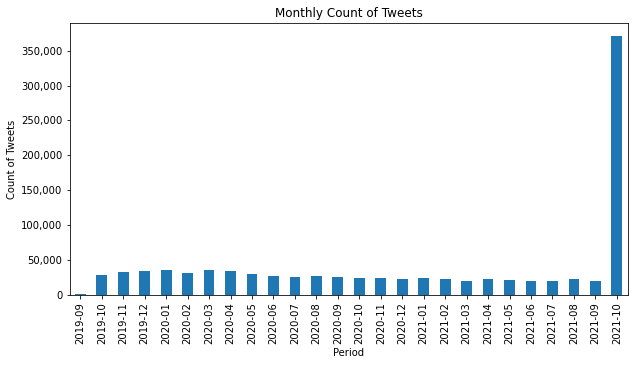

In [308]:
fig, ax = plt.subplots(figsize=(10,5))
df1['url'].plot(kind='bar', ax=ax)
ax.set_xlabel('Period')
ax.set_ylabel('Count of Tweets')
ax.set_title('Monthly Count of Tweets')
ax.get_yaxis().set_major_formatter(
ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

**October-2021 month has almost 30% of the total data which seem to be an artifact of the scrapping API. Limiting the dataset until Sept-2021**

## Dropping the Data for Oct-2021 Month

In [335]:
# filtering Oct-21 dates as the tweet count for this month contribute to 30% of the data
df1 = df[df['date'] < '2021-10-01']

## Location Data Analysis

In [430]:
df1['location'].to_csv('../output/data/location_data.csv')

**Checking for Unique Locations**

In [429]:
df1['location'].value_counts()

                            41516
India                       40561
New Delhi, India            39042
Mumbai, India               36587
Chennai, India              18304
                            ...  
Reaching For Every Star         1
MIM ❤                           1
universe                        1
Cole World/Hope World           1
ÜT: 34.081822,-118.36107        1
Name: location, Length: 12872, dtype: int64

**No-Location data is ranked number 1 in terms of value counts. Checking to see if countryCode is available for these tweets**

In [433]:
df1[df1['location']=='']['countryCode'].value_counts().sum()

41509

In [434]:
df1[df1['location']=='']['countryCode'].isnull().sum()

7

**Location Data is Blank for 41,516 rows. CountryCode data is available for 41,509 of them and 7 rows have no data at all**

In [435]:
df1[df1['location']=='']['countryCode'].value_counts()

IN    24005
MY     4048
PK     3035
AE     2595
TH     2174
OM     1342
SG      816
SA      432
MV      418
QA      404
BH      376
AF      259
YE      213
VN      197
KW      195
CN      162
LK      148
NP      121
BD      115
        108
SO       71
ID       58
IR       53
KH       53
BT       40
MM       36
KG       11
LA        8
UZ        8
TJ        3
IQ        3
TM        1
KZ        1
Name: countryCode, dtype: int64

In [446]:
df1[df1['countryCode'] != '']['countryCode'].value_counts().sum()

628612

In [441]:
df1.shape

(630496, 62)

**Country Code is available for 628,612 tweets, 1725 tweets have blank and rest are NaNs out of 630,496 tweets**

In [438]:
df1['countryCode'].value_counts()

IN    448262
PK     45696
AE     31644
MY     22740
TH     15096
LK     13805
SG     10146
QA      6054
SA      4978
NP      4347
MV      3782
OM      3216
BH      2879
SO      2685
AF      2525
VN      2492
BD      1765
        1725
CN      1276
IR      1001
MM       997
KW       945
KH       472
BT       331
YE       295
ID       290
KG       277
UZ       211
TJ       155
TM       100
LA        95
IQ        53
KZ         2
Name: countryCode, dtype: int64

## Keeping Tweets only for India

In [448]:
df1 = df1[df1['countryCode']=='IN']

## Number of Tweets Analysis

In [449]:
user_tweetcount = df1['username'].value_counts()

In [450]:
user_tweetcount = user_tweetcount.to_frame(name='tweetcount').reset_index().rename(columns={'index':'username'})

In [451]:
user_tweetcount

,username,tweetcount
0,rameshlaus,14577
1,hrnext,7770
2,payalmehta100,6648
3,SanjoyRoyTWA,6489
4,iFaridoon,5038
...,...,...
19911,katchannaidu,1
19912,zdobsizdub,1
19913,DDManipur,1
19914,Im_JEBIN,1


In [452]:
user_tweetcount_bins = pd.qcut(user_tweetcount['tweetcount'], 20, duplicates='drop', precision=0).value_counts().sort_index()

In [453]:
user_tweetcount_bins = user_tweetcount_bins.to_frame(name='bin_count').reset_index().rename(columns={'index':'bins'})
user_tweetcount_bins

,bins,bin_count
0,"(0.0, 2.0]",12536
1,"(2.0, 3.0]",1224
2,"(3.0, 4.0]",756
3,"(4.0, 5.0]",563
4,"(5.0, 8.0]",940
5,"(8.0, 14.0]",953
6,"(14.0, 29.0]",1006
7,"(29.0, 79.0]",960
8,"(79.0, 14577.0]",978


In [454]:
user_tweetcount_bins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   bins       9 non-null      category
 1   bin_count  9 non-null      int64   
dtypes: category(1), int64(1)
memory usage: 653.0 bytes


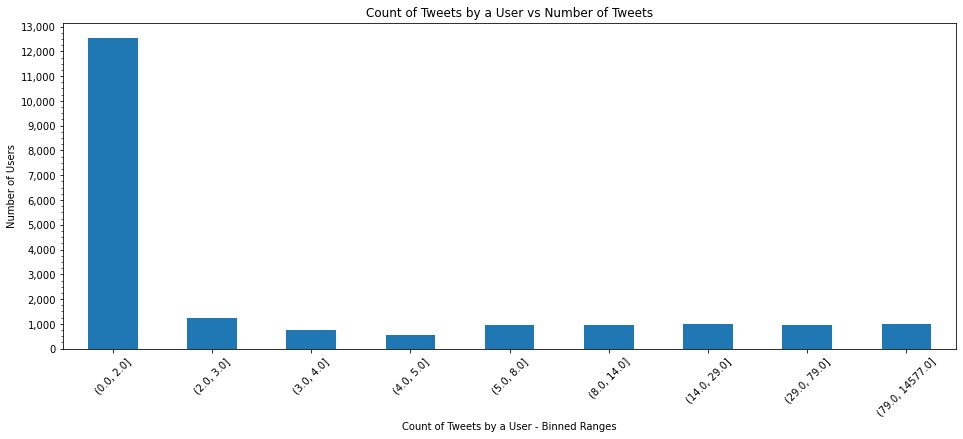

In [456]:
fig, ax = plt.subplots(figsize=(16,6))
user_tweetcount_bins.plot(kind='bar', ax=ax, x='bins', y='bin_count', logy=False)
ax.set_xlabel('Count of Tweets by a User - Binned Ranges')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
ax.set_ylabel('Number of Users')
ax.set_title('Count of Tweets by a User vs Number of Tweets')
ax.get_yaxis().set_major_formatter(
ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(250))
ax.get_legend().remove()
# ax.set_xlabel(user_tweetcount_bins['bins'].values)

## Tweet Lengths

In [463]:
df1['tweet_length'] = df1['content'].apply(lambda x: len(x))

/var/folders/vc/262dx0q508d6dv26phhy52ph0000gn/T/ipykernel_27888/1596478383.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['tweet_length'] = df1['content'].apply(lambda x: len(x))


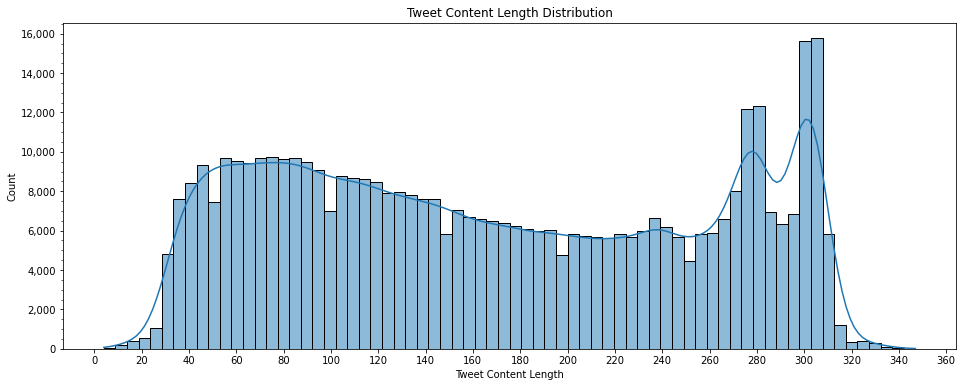

In [493]:
fig, ax = plt.subplots(figsize=(16,6))
sns.histplot(data=df1, x='tweet_length', ax=ax, bins=70, kde=True, common_bins=False)
ax.set_xlabel('Tweet Content Length')
ax.set_ylabel('Count')
ax.set_title('Tweet Content Length Distribution')
ax.get_yaxis().set_major_formatter(
ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.yaxis.set_major_locator(ticker.MultipleLocator(2000))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(500))
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))

In [507]:
fullName = df1['fullName'].value_counts()

In [508]:
fullName_df = fullName.to_frame(name='count').reset_index().rename(columns={'index':'name'})

In [ ]:
fullName_df

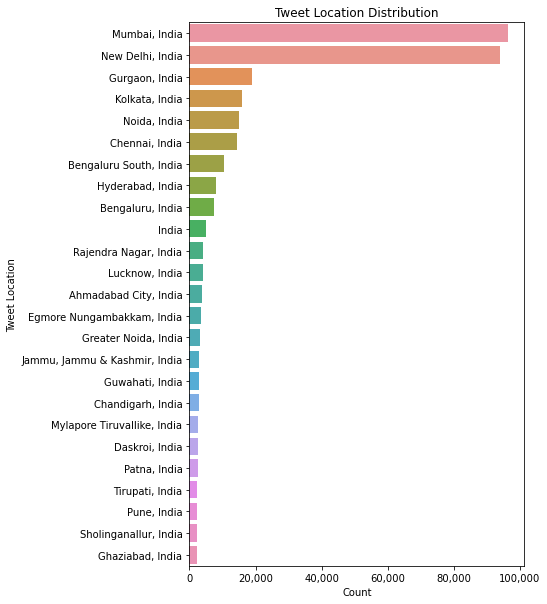

In [520]:
fig, ax = plt.subplots(figsize=(6,10))
sns.barplot(data=fullName_df.iloc[:25], x='count', y='name', ax=ax, orient='h')
ax.set_xlabel('Count')
ax.set_ylabel('Tweet Location')
ax.set_title('Tweet Location Distribution')
ax.get_xaxis().set_major_formatter(
ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.xaxis.set_major_locator(ticker.MultipleLocator(20000))
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(500))
# ax.xaxis.set_major_locator(ticker.MultipleLocator(20))

# Data Uncertainity and Risks

- Cursory look at the tweets that are being scraped vs a manual search on twitter website reveals not all the tweets are being captured. It is hard to pinpoint what is happening with the API. For e.g, month of October had 30% of tweets compared to the previous 23 months. Certain verified handles with known location of India are not getting scraped
- There are 12k unique users out 19k who have posted only between 1 to 2 tweets. The rest of the 7k users have posted the rest of 400k tweets. At this point, it is not clear if this will postively or negatively influence the modeling effort
- The volume of the tweets being scraped for a 2 year period seems to be too low so it might be mising vital tweets from that period
- The dataframe has over 400k rows and 65 columns. But not all the columns are critical to the modeling process. These columns will be dropped later after extensive EDA